In [1]:
import splat
import wisps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib inline

In [2]:
aegis=pd.read_pickle('aegis.pkl')

In [3]:
cosmos=pd.read_hdf(wisps.OUTPUT_FILES+'/indices.hdf', key='cosmos')

In [7]:
len(cosmos)

33639

In [8]:
ids=pd.concat([aegis, cosmos]).reset_index()

In [9]:
ids.columns

Index(['index', 'CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont', 'indices', 'name', 'snr', 'spectra'],
      dtype='object')

In [10]:
df=ids

In [11]:
from scipy import stats

In [14]:
def fit_a_line(wave, flux, noise):
    """
    Fit a line, returns a chi-square
    """
    m, b, r_value, p_value, std_err = stats.linregress(wave,flux)
    line=m*wave+b
    chisqr=np.nansum((flux-line)**2/noise**2)
    #print (chisqr)
    return line, chisqr
    
      

In [24]:
def f_test(x):
    return stats.f.pdf(x, 2, 1, 0, scale=1)

In [55]:
def flag(sp):
    """
    compare chi-square from line vs chi-square from standard
    """
    try:
        s=sp.splat_spectrum
        s.trim([1.15, 1.65])
        line, chi=fit_a_line(s.wave.value, s.flux.value, s.noise.value)
        spt, spexchi=splat.classifyByStandard(s, return_statistic=True, fit_ranges=[[1.1, 1.65]], plot=False)
        return {'spex_chi':spexchi, 'line_chi':chi, 'spt':spt}
    except:
        return {'spex_chi':np.nan, 'line_chi':np.nan, 'spt':spt}

In [19]:
def compare_to_line(sp):
    """
    Plot a spectrum compared to a line
    """
    s=sp.splat_spectrum
    s.trim([1.15, 1.65])
    fig, ax=plt.subplots()
    
    line, chi=fit_a_line(s.wave.value, s.flux.value, s.noise.value)
    spt, spexchi=splat.classifyByStandard(s, return_statistic=True, fit_ranges=[[1.1, 1.65]], plot=False)
    spex_std=splat.STDS_DWARF_SPEX[spt]
    spex_std.normalize()
    scale=splat.compareSpectra( s, spex_std,fit_ranges=[[1.1, 1.65]])[0].value

    spex_std.scale(scale)

    ax.plot(sp.wave, sp.flux, c='#AAAAAA')
    ax.plot(spex_std.wave, spex_std.flux/scale, c='#0074D9', label=str(spt)+' $\chi^2$= {0:.{1}f}'.format(spexchi, 0))
    ax.plot(s.wave,line, c='#111111', label='$\chi^2$= {0:.{1}f}'.format(chi, 0))
    
    f=interpolate.interp1d( spex_std.wave.value,  spex_std.flux.value/scale)
    plt.plot(s.wave, abs(s.flux.value-f(np.linspace(1.15, 1.65, len(s.wave)))), c='#2ECC40', label='abs difference')
    plt.xlim([1.1, 1.65])
    plt.ylim([np.nanmin(s.flux.value), np.nanmax(s.flux.value)])
    plt.legend()

In [15]:
#compare_to_line(df.loc[524].spectra)

Plot a distribution of both chisqrs 

In [20]:
#compare_to_line(df.loc[207].spectra)

In [38]:
#ids.loc[0]

In [16]:
chis=ids.spectra.apply(flag)

In [18]:
#chis

In [19]:
chidf=pd.DataFrame([x for x in chis])
tot_df=ids.merge(chidf, how='outer', left_index=True, right_index=True)

In [20]:
import seaborn as sns

In [21]:
x=tot_df.spex_chi/tot_df.line_chi

Text(0.5,0,' $\\chi^2_{s} / \\chi^2_{l} $')

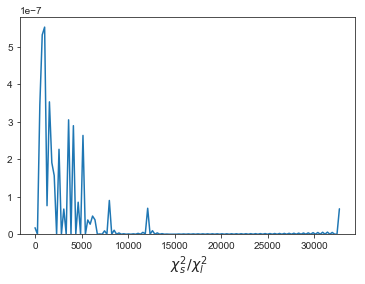

In [22]:
fig, ax=plt.subplots()
sns.kdeplot(x, ax=ax)
#ax.set_xlim([-1, 10.0])
ax.set_xlabel(' $\chi^2_{s} / \chi^2_{l} $', fontsize=14)
#plt.legend(fontsize=14)

(-10, 4)

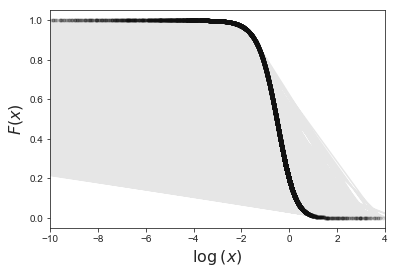

In [25]:
f=f_test(x)
fig, ax=plt.subplots()
#ax.set_xscale('log')
plt.plot( np.log10(x), f, '.-', alpha=0.1, c='#111111')
ax.set_xlabel('$\log \: (x) $', fontsize=16)
ax.set_ylabel('$ F(x)$', fontsize=16)
ax.set_xlim([-10, 4])

In [41]:
#tot_df.loc[0].spectra.snr

In [26]:
#let's look at 
tot_df['t_snr']=np.array([s.snr['l_t_snr'] for s in tot_df.spectra])

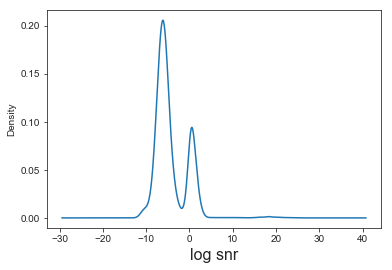

In [27]:
fig, ax=plt.subplots()
ax.set_xlabel('log snr', fontsize=16)
tot_df[f>.5].t_snr.apply(np.log10).plot(kind='kde', ax=ax)

In [28]:
len(tot_df[f>.7])

8076

In [31]:
len(tot_df[(f>.5) & (tot_df.t_snr>5.0)])

429

In [32]:
len(tot_df[tot_df.t_snr>5.0])

4690

In [33]:
tot_df[(f>.5) & (tot_df.t_snr>5.0)].to_pickle(wisps.OUTPUT_FILES+'/aegis_cut.pkl')

In [51]:
fdf=tot_df.drop(columns=['index', 'indices', 'spectra', 'snr'])

In [52]:
fdf['f_test']=f

In [53]:
def reformat_table(df):
    """
    drop uncertainties
    """
    new_df=pd.DataFrame()
    for k in df.columns: 
        if isinstance(df[k].iloc[0], tuple):
            new_df[k]=np.array(np.apply_along_axis(list, 0, df[k].values))[:,0]
        else:
            new_df[k]=df[k]
    return new_df

In [61]:
#fdf=fdf.drop(columns=['snr'])

In [64]:
ids.spectra.iloc[0].snr

{'l_t_snr': 2.6371120391958913e-09,
 'median_snr': 2.6298638757058976e-09,
 'cdf_snr': nan,
 't_snr': 2.656967656546535e-09}

In [65]:
fdf['l_snr']=ids.spectra.apply(lambda x: x.snr['t_snr'])
fdf['l_t_snr']=ids.spectra.apply(lambda x: x.snr['l_t_snr'])
fdf['med_snr']=ids.spectra.apply(lambda x: x.snr['median_snr'])
fdf['cdf_snr']=ids.spectra.apply(lambda x: x.snr['cdf_snr'])

KeyError: 't_snr'

In [57]:
fdf.to_pickle(wisps.LIBRARIES+'aegis_cosmos.pkl')

,index,CH_4/H-Cont,CH_4/H_2O-1,CH_4/H_2O-2,CH_4/J-Cont,H-cont/H_2O-1,H-cont/H_2O-2,H-cont/J-Cont,H_2O-1/J-Cont,H_2O-2/H_2O-1,H_2O-2/J-Cont,indices,name,snr,spectra,f_x
0,0,"(0.9755859536556895, 122.5962009849862)","(0.9442367618738785, 206.31680993544268)","(0.9198783068679358, 10.606382617139266)","(0.9062421871550455, 25.668204715980494)","(0.9678662944414687, 26.854323314367637)","(0.9428982689029015, 102.30308923822938)","(0.9289209051844167, 22.39870160174641)","(0.9597616019064634, 17.494503904880954)","(1.0264800841851354, 25.969675499073755)","(0.9851761699226069, 1174.21072859328)",NaN,aegis-01-G141_10532.1D.ascii,NaN,aegis-01-G141_10532.1D.ascii,0.149756
1,1,"(nan, 14.868641022496423)","(0.0, 297.2637859445761)","(0.0, 77.90574774854842)","(0.0, 93.38939136808023)","(0.0, 56.06551994381923)","(0.0, 80.81234705248927)","(0.0, 13.777298230631184)","(0.9995289846196505, 39.056362960572024)","(1.0005576768257711, 22.262746987488924)","(1.0000863987710593, 448.3362912251564)",NaN,aegis-01-G141_10898.1D.ascii,69.195094,aegis-01-G141_10898.1D.ascii,0.980705
2,2,"(nan, 11.382952423805854)","(nan, 81.03480526869753)","(0.0, 123.90562400999164)","(nan, 65.57142332915573)","(nan, 21.955428577333088)","(0.0, 17.854011603969273)","(nan, 20.471553445025144)","(nan, 85.07735574060527)","(inf, 256.3130879144186)","(inf, 9.376363100997178)",NaN,aegis-01-G141_10910.1D.ascii,NaN,aegis-01-G141_10910.1D.ascii,0.998207
3,3,"(inf, 12.929643542413597)","(inf, 35.31288359066627)","(0.798313954562113, 29.876280302519504)","(1.256530523404537, 21.760534329282834)","(nan, 64.03090913696916)","(0.0, 17.453368518811548)","(0.0, 27.677937822107868)","(0.0, 250.33969267767407)","(inf, 104.95094485137666)","(1.5739804073621166, 80.2078523106541)",NaN,aegis-01-G141_10937.1D.ascii,NaN,aegis-01-G141_10937.1D.ascii,0.841865
4,4,"(nan, 176.31496233423837)","(nan, 74.76716370190482)","(0.0, 55.173708476237856)","(nan, 16.499745482137513)","(nan, 36.46159493131194)","(0.0, 190.19935457642507)","(nan, 40.968983425362204)","(nan, 14.107657284180172)","(inf, 19.865903383895088)","(inf, 18.81158090674705)",NaN,aegis-01-G141_10951.1D.ascii,133.602464,aegis-01-G141_10951.1D.ascii,0.999960
5,5,"(nan, 105.89591585316283)","(0.0, 82.12681818618674)","(0.0, 63.289626639864274)","(0.0, 20.028003755816734)","(0.0, 302.6759671115553)","(0.0, 29.543969210290314)","(0.0, 13.184727094915107)","(0.9874747075433749, 20.83554025748385)","(0.9626986539622915, 26.630682299301437)","(0.9506405717738143, 20.779415334680657)",NaN,aegis-01-G141_10994.1D.ascii,NaN,aegis-01-G141_10994.1D.ascii,0.993597
6,6,"(0.9146109714266628, 40.146470618810156)","(inf, 27.68743483143611)","(5.111341849495049, 21.540401634739872)","(inf, 25.12681205001375)","(inf, 97.59879954062819)","(5.588542024071812, 407.3535157768775)","(inf, 69.75253329409689)","(nan, 72.65972215744492)","(inf, 362.05223704978323)","(inf, 12.938020864085852)",NaN,aegis-01-G141_10998.1D.ascii,NaN,aegis-01-G141_10998.1D.ascii,0.994711
7,7,"(inf, 504.23202466209057)","(0.17699360678764145, 237.69042653586143)","(0.28071382034715786, 12.294738158203248)","(0.17461302736604137, 26.280784530165466)","(0.0, 29.639952869489733)","(0.0, 456.04479813327066)","(0.0, 57.475195927323064)","(0.9865499129329777, 19.553875502636767)","(0.6305126216042873, 95.02361210103433)","(0.6220321719468532, 36.62858951265879)",NaN,aegis-01-G141_11033.1D.ascii,110.360555,aegis-01-G141_11033.1D.ascii,0.989647
8,8,"(3.2965714019048815, 28.221388013602418)","(inf, 182.3205711551102)","(51.27542357382625, 95.07024124658909)","(inf, 15.366138547440976)","(inf, 22.934947768375377)","(15.554167443240393, 11.058731591055068)","(inf, 13.531822375820502)","(nan, 212.2826374081117)","(inf, 22.092600752874084)","(inf, 214.05720679531692)",NaN,aegis-01-G141_11058.1D.ascii,198.588115,aegis-01-G141_11058.1D.ascii,0.117581
9,9,"(0.16060131613707002, 7.8059490266498495)","(inf, 183.17056992621013)","(0.1557987271646679, 68.18625836634301)","(inf, 10.243200351332005)","

In [59]:
fdf

,CH_4/H-Cont,CH_4/H_2O-1,CH_4/H_2O-2,CH_4/J-Cont,H-cont/H_2O-1,H-cont/H_2O-2,H-cont/J-Cont,H_2O-1/J-Cont,H_2O-2/H_2O-1,H_2O-2/J-Cont,name,line_chi,spex_chi,t_snr,f_test
0,"(0.9755859536556895, 122.5962009849862)","(0.9442367618738785, 206.31680993544268)","(0.9198783068679358, 10.606382617139266)","(0.9062421871550455, 25.668204715980494)","(0.9678662944414687, 26.854323314367637)","(0.9428982689029015, 102.30308923822938)","(0.9289209051844167, 22.39870160174641)","(0.9597616019064634, 17.494503904880954)","(1.0264800841851354, 25.969675499073755)","(0.9851761699226069, 1174.21072859328)",aegis-01-G141_10532.1D.ascii,3.268520e-17,4.160887e-17,2.637112e-09,0.149756
1,"(nan, 14.868641022496423)","(0.0, 297.2637859445761)","(0.0, 77.90574774854842)","(0.0, 93.38939136808023)","(0.0, 56.06551994381923)","(0.0, 80.81234705248927)","(0.0, 13.777298230631184)","(0.9995289846196505, 39.056362960572024)","(1.0005576768257711, 22.262746987488924)","(1.0000863987710593, 448.3362912251564)",aegis-01-G141_10898.1D.ascii,9.654819e-13,6.311185e-15,4.847954e-08,0.980705
2,"(nan, 11.382952423805854)","(nan, 81.03480526869753)","(0.0, 123.90562400999164)","(nan, 65.57142332915573)","(nan, 21.955428577333088)","(0.0, 17.854011603969273)","(nan, 20.471553445025144)","(nan, 85.07735574060527)","(inf, 256.3130879144186)","(inf, 9.376363100997178)",aegis-01-G141_10910.1D.ascii,9.314631e-11,5.576530e-14,-2.643035e-08,0.998207
3,"(inf, 12.929643542413597)","(inf, 35.31288359066627)","(0.798313954562113, 29.876280302519504)","(1.256530523404537, 21.760534329282834)","(nan, 64.03090913696916)","(0.0, 17.453368518811548)","(0.0, 27.677937822107868)","(0.0, 250.33969267767407)","(inf, 104.95094485137666)","(1.5739804073621166, 80.2078523106541)",aegis-01-G141_10937.1D.ascii,8.046653e-11,4.892399e-12,-4.147107e-07,0.841865
4,"(nan, 176.31496233423837)","(nan, 74.76716370190482)","(0.0, 55.173708476237856)","(nan, 16.499745482137513)","(nan, 36.46159493131194)","(0.0, 190.19935457642507)","(nan, 40.968983425362204)","(nan, 14.107657284180172)","(inf, 19.865903383895088)","(inf, 18.81158090674705)",aegis-01-G141_10951.1D.ascii,9.803294e-11,1.302085e-15,-2.213749e-08,0.999960
5,"(nan, 105.89591585316283)","(0.0, 82.12681818618674)","(0.0, 63.289626639864274)","(0.0, 20.028003755816734)","(0.0, 302.6759671115553)","(0.0, 29.543969210290314)","(0.0, 13.184727094915107)","(0.9874747075433749, 20.83554025748385)","(0.9626986539622915, 26.630682299301437)","(0.9506405717738143, 20.779415334680657)",aegis-01-G141_10994.1D.ascii,5.804477e-08,1.245456e-10,4.705538e-06,0.993597
6,"(0.9146109714266628, 40.146470618810156)","(inf, 27.68743483143611)","(5.111341849495049, 21.540401634739872)","(inf, 25.12681205001375)","(inf, 97.59879954062819)","(5.588542024071812, 407.3535157768775)","(inf, 69.75253329409689)","(nan, 72.65972215744492)","(inf, 362.05223704978323)","(inf, 12.938020864085852)",aegis-01-G141_10998.1D.ascii,1.146803e-11,2.030853e-14,-3.232403e-08,0.994711
7,"(inf, 504.23202466209057)","(0.17699360678764145, 237.69042653586143)","(0.28071382034715786, 12.294738158203248)","(0.17461302736604137, 26.280784530165466)","(0.0, 29.639952869489733)","(0.0, 456.04479813327066)","(0.0, 57.475195927323064)","(0.9865499129329777, 19.553875502636767)","(0.6305126216042873, 95.02361210103433)","(0.6220321719468532, 36.62858951265879)",aegis-01-G141_11033.1D.ascii,3.691953e-12,1.285156e-14,2.977368e-08,0.989647
8,"(3.2965714019048815, 28.221388013602418)","(inf, 182.3205711551102)","(51.27542357382625, 95.07024124658909)","(inf, 15.366138547440976)","(inf, 22.934947768375377)","(15.554167443240393, 11.058731591055068)","(inf, 13.531822375820502)","(nan, 212.2826374081117)","(inf, 22.092600752874084)","(inf, 214.05720679531692)",aegis-01-G141_11058.1D.ascii,1.062880e-10,1.682827e-10,-8.840089e-07,0.117581
9,"(0.16060131613707002, 7.8059490266498495)","(inf, 183.17056992621013)","(0.1557987271646679, 68.18625836634301)","(inf, 10.243200351332005)","(inf, 139.6090784815347

In [1]:
fdf

NameError: name 'fdf' is not defined